1. Train and Save the Model

1.1 Prepare the Dataset

In [1]:
import os
from PIL import Image
import pillow_heif
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
# # Custom loader to handle .HEIC files
# def pil_loader(path):
#     with open(path, 'rb') as f:
#         image = Image.open(f)
#         return image.convert('RGB')

# # Use DatasetFolder instead of ImageFolder to specify the custom loader
# train_dataset = DatasetFolder(root='.img/train', loader=pil_loader, extensions=('jpg', 'jpeg', 'png', 'heic'), transform=transform)
# validation_dataset = DatasetFolder(root='.img/validation', loader=pil_loader, extensions=('jpg', 'jpeg', 'png', 'heic'), transform=transform)

In [4]:
# Load the datasets
train_dataset = datasets.ImageFolder(root='img/train', transform=transform)

validation_dataset = datasets.ImageFolder(root='img/validation', transform=transform)

In [5]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

1.2 Build or Load the Model

In [6]:
# class BinaryImageClassifier(nn.Module):
#     def __init__(self):
#         super(BinaryImageClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(128 * 18 * 18, 512)
#         self.fc2 = nn.Linear(512, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = self.pool(torch.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 18 * 18)
#         x = torch.relu(self.fc1(x))
#         x = self.sigmoid(self.fc2(x))
#         return x

# model = BinaryImageClassifier()

In [7]:
# Load a pretrained model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Replace the final layer to match the number of classes (binary classification in this case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Define loss function and optimizer
#criterion = nn.BCELoss()
# for binary classification,
# combines a sigmoid layer and the binary cross-entropy loss in one single class.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

1.3 Train the Model

In [8]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        labels = labels.unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            labels = labels.unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f'Validation Loss: {val_loss/len(validation_loader):.4f}')

Epoch [1/10], Loss: 0.6719
Validation Loss: 1.1732
Epoch [2/10], Loss: 0.0799
Validation Loss: 0.6816
Epoch [3/10], Loss: 0.1845
Validation Loss: 0.3205
Epoch [4/10], Loss: 0.0087
Validation Loss: 1.5875
Epoch [5/10], Loss: 0.0034
Validation Loss: 2.4811
Epoch [6/10], Loss: 0.0013
Validation Loss: 2.7725
Epoch [7/10], Loss: 0.0007
Validation Loss: 2.7036
Epoch [8/10], Loss: 0.0004
Validation Loss: 2.4383
Epoch [9/10], Loss: 0.0003
Validation Loss: 2.0938
Epoch [10/10], Loss: 0.0003
Validation Loss: 1.7416


1.4 Save the Model

In [24]:
date = datetime.now().date()
date = date.strftime("%Y_%m_%d")

# Save the model to a file
torch.save(model.state_dict(), f'models/{date}_binary_image_classifier.pth')

Example

In [39]:
# Load the state dictionary
state_dict = torch.load(f'models/{date}_binary_image_classifier.pth')

/var/folders/p6/0v7dt7_x1p336nsn9fhywqq40000gn/T/ipykernel_32589/1590909270.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'models/{date}_binar

In [37]:

# Load the trained model
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Load the state dictionary
state_dict = torch.load(f'models/{date}_binary_image_classifier.pth')
model.load_state_dict(state_dict)
model.eval() # inference

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Function to classify a single image
def classify_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Classify the image
    with torch.no_grad():
        output = model(image)
        prediction = torch.sigmoid(output).item()
        label = 'yes' if prediction >= 0.5 else 'no'

    # Display the image with the classification label
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()

/var/folders/p6/0v7dt7_x1p336nsn9fhywqq40000gn/T/ipykernel_32589/650136842.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'models/{date}_binary

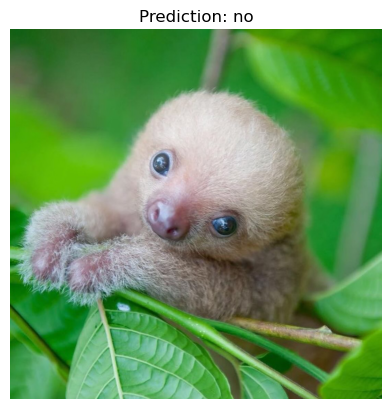

In [28]:
# Example usage
img_path = 'img/example/no_sloth.jpg'
classify_image(img_path)


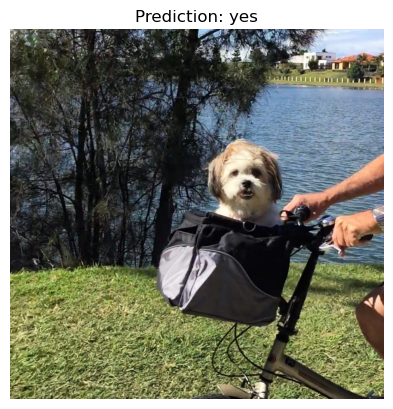

In [34]:
img_path = 'img/example/yes_dog_1.jpg'
classify_image(img_path)

2. Create a Web Service

In [ ]:
# app.py
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Load the model
model = joblib.load('model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    prediction = model.predict([data['features']])
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

3. Containerize the Application

In [ ]:
# Dockerfile
FROM python:3.8-slim

WORKDIR /app

COPY requirements.txt requirements.txt
RUN pip install -r requirements.txt

COPY . .

CMD ["python", "app.py"]

```
# requirements.txt
Flask
scikit-learn
joblib
```

4. Deploy the Container

In [ ]:
# Build the Docker image
docker build -t binary-classifier .

# Run the Docker container locally
docker run -p 5000:5000 binary-classifier

# Push the Docker image to a container registry (e.g., Docker Hub)
docker tag binary-classifier your-dockerhub-username/binary-classifier
docker push your-dockerhub-username/binary-classifier

# Deploy to a cloud service (e.g., AWS ECS, Azure Container Instances, Google Cloud Run)